# 1D illustration

In [1]:
# import standard libraries

from mfbml.methods.krr_lr_gpr import KernelRidgeLinearGaussianProcess as KRRLRGPR
from mfbml.methods.kernel_ridge_regression import KernelRidgeRegression as RBFKernelRegression
from mfbml.problems.illustrative_problems import mf_Forrester

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#
import warnings

warnings.filterwarnings("ignore")

In [2]:
# fix the random seed for reproducibility
seed_number = 1996
np.random.seed(seed_number)

## KRR-LR-GPR for noisy data


In [3]:
func = mf_Forrester()

# get the samples use np.linspace
sample_hx = np.linspace(0, 1, 7).reshape(-1, 1)
sample_lx = np.linspace(0, 1, 200).reshape(-1, 1)
sample_x = [sample_hx, sample_lx]

# get the high and low fidelity responses
sample_y = [func.hf(sample_hx), func.lf_2(sample_lx)]

# add noise to the samples
sample_y[0] += np.random.normal(0, 0.3, sample_y[0].shape)
sample_y[1] += np.random.normal(0, 0.3, sample_y[1].shape)
# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf_2(test_x)

# test data noise)
test_hy_noise = test_hy + np.random.normal(0, 0.3, test_hy.shape)
test_ly_noise = test_hy + np.random.normal(0, 0.3, test_ly.shape)

In [4]:
model_noisy = KRRLRGPR(
    design_space=func.design_space,
    optimizer_restart=10,
    seed=seed_number,
)
model_noisy.lf_model = RBFKernelRegression(design_space=func.design_space,
                                           optimizer_restart=10,
                                           noise_data=True,
                                           seed=seed_number)
model_noisy.train(X=sample_x, Y=sample_y)
pred_y, pred_std = model_noisy.predict(X=test_x, return_std=True)
# get prediction of low fidelity
pred_ly = model_noisy.predict_lf(X=test_x)
# calculate accuracy metrics

lf_training_time_noisy = model_noisy.lf_training_time
hf_training_time_noisy = model_noisy.hf_training_time

print("lf time", lf_training_time_noisy)
print("hf time", hf_training_time_noisy)
print("noise", model_noisy.noise)

lf time 8.884217262268066
hf time 0.15264320373535156
noise 6.103937515794927e-05


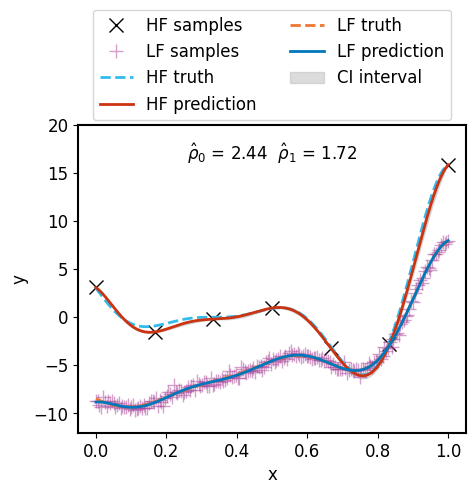

In [5]:
# visualize the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x[0],
    sample_y[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax.plot(
    sample_x[1],
    sample_y[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax.plot(test_x, test_hy, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x, pred_y, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.plot(test_x, test_ly, "--", color="#EE7733",
        linewidth=2, label="LF truth")
ax.plot(test_x, pred_ly, "-", color="#0077BB",
        linewidth=2, label="LF prediction")
ax.fill_between(
    test_x.flatten(),
    (pred_y - 2 * pred_std).flatten(),
    (pred_y + 2 * pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()

ax.text(
    0.5,
    17.0,
    r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
        model_noisy.beta[0, 0], model_noisy.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=font_size)
# set the line width of the axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

plt.show()

### Noiseless case

In [6]:
# get the samples use np.linspace
sample_hx_noiseless = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
sample_lx_noiseless = np.linspace(0, 1, 11, endpoint=True).reshape((-1, 1))
sample_x_noiseless = [sample_hx_noiseless, sample_lx_noiseless]

# get the high and low fidelity responses
sample_y_noiseless = [func.hf(sample_hx_noiseless),
                      func.lf_2(sample_lx_noiseless)]

# generate test samples
test_x_noiseless = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noiseless = func.hf(test_x_noiseless)
test_ly_noiseless = func.lf_2(test_x_noiseless)

In [7]:
# model without noise
model_noiseless = KRRLRGPR(
    design_space=func.design_space,
    optimizer_restart=10,
    seed=seed_number,
    noise_prior=0.0,
)
model_noiseless.lf_model = RBFKernelRegression(design_space=func.design_space,
                                               optimizer_restart=10,
                                               noise_data=False,
                                               seed=seed_number)
model_noiseless.train(X=sample_x_noiseless, Y=sample_y_noiseless)
pred_y_noiseless, pred_std_noiseless = model_noiseless.predict(
    X=test_x_noiseless, return_std=True)
# get prediction of low fidelity
pred_ly_noiseless = model_noiseless.predict_lf(X=test_x_noiseless)

# get the training time
lf_training_time_noiseless = model_noiseless.lf_training_time
hf_training_time_noiseless = model_noiseless.hf_training_time

# print the training time
print("lf time", lf_training_time_noiseless)
print("hf time", hf_training_time_noiseless)
print("noise", model_noiseless.noise)

lf time 0.4049513339996338
hf time 0.020384550094604492
noise 0.0


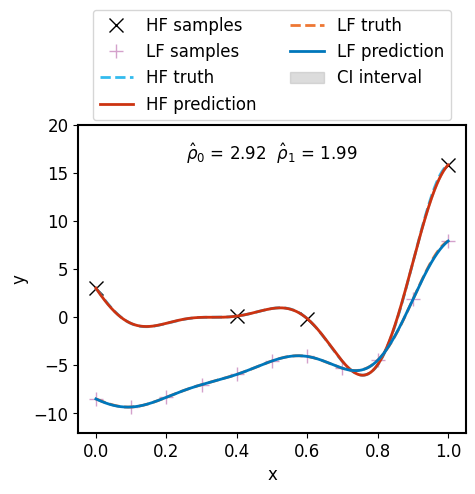

In [8]:
# plot the results
font_size = 12
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(
    sample_x_noiseless[0],
    sample_y_noiseless[0],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax.plot(
    sample_x_noiseless[1],
    sample_y_noiseless[1],
    "+",
    color="#AA4499",
    linewidth=2,
    markersize=10,
    alpha=0.5,
    label="LF samples",
)
ax.plot(test_x_noiseless, test_hy_noiseless, "--", color="#33BBEE",
        linewidth=2, label="HF truth")
ax.plot(test_x_noiseless, pred_y_noiseless, "-", color="#CC3311",
        linewidth=2, label="HF prediction")
ax.plot(test_x_noiseless, test_ly_noiseless, "--", color="#EE7733",
        linewidth=2, label="LF truth")
ax.plot(test_x_noiseless, pred_ly_noiseless, "-", color="#0077BB",
        linewidth=2, label="LF prediction")
ax.fill_between(
    test_x_noiseless.flatten(),
    (pred_y_noiseless - 2 * pred_std_noiseless).flatten(),
    (pred_y_noiseless + 2 * pred_std_noiseless).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax.set_ylabel("y", fontsize=font_size)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylim(-12, 20)
ax.legend()

ax.text(
    0.5,
    17.0,
    r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
        model_noiseless.beta[0, 0], model_noiseless.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=2, fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=font_size)
# set the line width of the axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

plt.show()